# Layer activation normalization (Batch normalization)

Just as we normalize or standardize the input variables, networks train better if we normalize the output of each layer's activation. These activations are the input to the next layer. In this way we normalize the input to every layer. called batch normalization because we normally train with batches not the entire data set. But it's really just fixing the mean and variance of each layer activation to zero mean and unit variance.  This is not joint distribution. Each neuron activation "whitened" independently. Then we scale and shift using two new model parameters to support same representation as previous layer activation. At test time, we use mean/var estimated during training for activtions to whiten the activations as the test instance sails through the network.  the learned parameters scale and shift but do not change the shape of the distribution. helps move gradients through the network.

as training progresses, the input to a hidden layer changes distribution (internal covariate shift), which means that the hidden layer weights must change as well. Small changes at the first layer amplify through deep networks. As with normalizing the input layer, it is believed to support faster learning rates for faster training. It also has a regularization effect, improving model generality. The model could also be less sensitive to the initialization procedure.  See [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167) for more information.

because mean/var computed on mini-batch we get some noise, which regularizes like dropout. Andrew Ng says slight effect, not as good as dropout for regularization. More about speeding up training.

See video [Why Does Batch Norm Work?](https://www.youtube.com/watch?v=nUUqwaxLnWs)

## Support code

In [1]:
import sys
import torch
import copy
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from matplotlib import colors 
import colour

%config InlineBackend.figure_format = 'retina'

import tsensor

In [2]:
def plot_history(history, ax=None, maxy=None, file=None):
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(3.5,3))
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    loss = history[:,0]
    val_loss = history[:,1]
    if maxy:
        ax.set_ylim(0,maxy)
    else:
        ax.set_ylim(0,torch.max(val_loss))
    ax.plot(loss, label='train_loss')
    ax.plot(val_loss, label='val_loss')
    ax.legend(loc='upper right')
    plt.tight_layout()
    if file:
        plt.savefig(f"/Users/parrt/Desktop/{file}.pdf")

In [3]:
def train(model, X_train, X_test, y_train, y_test,
          learning_rate = .5, nepochs=2000, weight_decay=0):
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, weight_decay=weight_decay)
    history = [] # track training and validation loss
    best_loss = 1e10
    best_model = None
    for epoch in range(nepochs+1):
        y_pred = model(X_train)
        loss = torch.mean((y_pred - y_train)**2)

        y_pred_test = model(X_test)
        loss_test = torch.mean((y_pred_test - y_test)**2)
        history.append((loss, loss_test))
        if loss_test < best_loss:
            best_loss = loss_test
            best_model = copy.deepcopy(model)
            best_epoch = epoch
        if epoch % (nepochs//10) == 0:
            print(f"Epoch {epoch:4d} MSE train loss {loss:12.3f}   test loss {loss_test:12.3f}")
            
        optimizer.zero_grad()
        loss.backward() # autograd computes w1.grad, b1.grad, ...
        optimizer.step()
    print(f"BEST MSE test loss {best_loss:.3f} at epoch {best_epoch}")
    return torch.tensor(history), best_model

In [4]:
d = load_diabetes()
len(d.data)

442

In [5]:
df = pd.DataFrame(d.data, columns=d.feature_names)
df['disease'] = d.target # "quantitative measure of disease progression one year after baseline"
df.head(3)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930,141.0


## Split data into train, validation sets

We'll use "test" as shorthand for "validation" but technically they are not the same.

In [6]:
np.random.seed(1) # set a random seed for consistency across runs
n = len(df)
n_test = int(n*0.20) # 20% held out as validation set
n_train = n - n_test
X = df.drop('disease',axis=1).values
y = df['disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=n_test)

In [7]:
m = np.mean(X_train,axis=0)
std = np.std(X_train,axis=0)
X_train = (X_train-m)/std
X_test = (X_test-m)/std       # use training data only when prepping test sets

## Baseline with random forest

In [8]:
rf = RandomForestRegressor(n_estimators=500)#, min_samples_leaf=2, max_features=1)
rf.fit(X_train, y_train.reshape(-1))
y_pred = rf.predict(X_train)
mse = np.mean((y_pred - y_train.reshape(-1))**2)

y_pred = rf.predict(X_test)
mse_test = np.mean((y_pred - y_test.reshape(-1))**2)

print(f"Training MSE {mse:.2f} validation MSE {mse_test:.2f}")

Training MSE 455.43 validation MSE 3405.60


In [9]:
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float().reshape(-1,1) # column vector
y_test = torch.tensor(y_test).float().reshape(-1,1)

## No batch normalization

Epoch    0 MSE train loss    29804.855   test loss    25904.449
Epoch   50 MSE train loss     2673.905   test loss     3089.395
Epoch  100 MSE train loss     2367.475   test loss     3143.382
Epoch  150 MSE train loss     2149.427   test loss     3257.823
Epoch  200 MSE train loss     1858.813   test loss     3425.332
Epoch  250 MSE train loss     1575.305   test loss     3747.294
Epoch  300 MSE train loss     1350.103   test loss     3875.959
Epoch  350 MSE train loss     1124.037   test loss     4030.516
Epoch  400 MSE train loss      883.519   test loss     4189.282
Epoch  450 MSE train loss      657.578   test loss     4424.304
Epoch  500 MSE train loss      505.857   test loss     4655.804
BEST MSE test loss 3073.239 at epoch 47


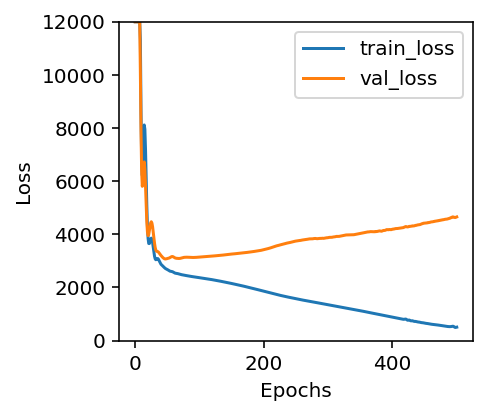

In [21]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.05, nepochs=500,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization prior to nonlinearity


Epoch    0 MSE train loss    29939.264   test loss    26019.082
Epoch   50 MSE train loss     2588.918   test loss     3294.431
Epoch  100 MSE train loss     2336.855   test loss     3250.537
Epoch  150 MSE train loss     2248.278   test loss     3290.748
Epoch  200 MSE train loss     2183.400   test loss     3304.034
Epoch  250 MSE train loss     2138.810   test loss     3304.105
Epoch  300 MSE train loss     2108.021   test loss     3311.621
Epoch  350 MSE train loss     2084.515   test loss     3314.131
Epoch  400 MSE train loss     2063.641   test loss     3338.643
Epoch  450 MSE train loss     2045.600   test loss     3325.681
Epoch  500 MSE train loss     2027.850   test loss     3336.882
BEST MSE test loss 2997.867 at epoch 30


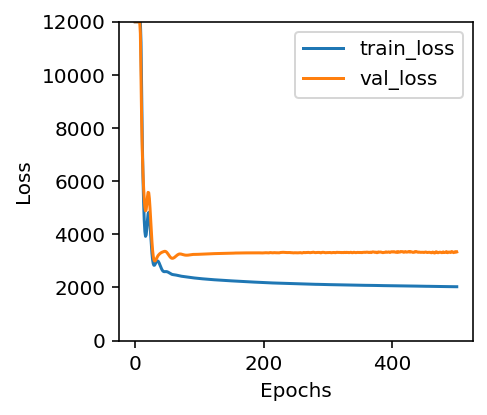

In [22]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.BatchNorm1d(n_neurons),
    nn.ReLU(),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.05, nepochs=500,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

## Batch normalization after nonlinearity

Epoch    0 MSE train loss    29837.760   test loss    25952.596
Epoch   50 MSE train loss     2133.403   test loss     4006.224
Epoch  100 MSE train loss     1330.381   test loss     4644.502
Epoch  150 MSE train loss      648.187   test loss     5645.668
Epoch  200 MSE train loss      326.138   test loss     7458.147
Epoch  250 MSE train loss      152.155   test loss     7542.625
Epoch  300 MSE train loss       70.788   test loss     7753.522
Epoch  350 MSE train loss       41.861   test loss     8106.575
Epoch  400 MSE train loss       37.327   test loss     8231.574
Epoch  450 MSE train loss       30.652   test loss     8337.584
Epoch  500 MSE train loss       72.577   test loss     8584.348
BEST MSE test loss 3073.734 at epoch 19


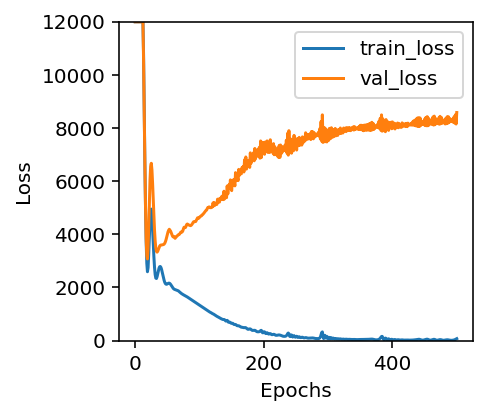

In [23]:
ncols = X.shape[1]
n_neurons = 200
model = nn.Sequential(
    nn.Linear(ncols, n_neurons),
    nn.ReLU(),
    nn.BatchNorm1d(n_neurons),
    nn.Linear(n_neurons, 1)
)

history, best_model = train(model, X_train, X_test, y_train, y_test,
                            learning_rate=.05, nepochs=500,
                            weight_decay=0)

# verify we got the best model out
y_pred = best_model(X_test)
loss_test = torch.mean((y_pred - y_test)**2)

plot_history(torch.clamp(history, 0, 12000))

At least for this data set and a random train/test set, batch normalization gives us much faster convergence to the best validation loss and also we get a lower test loss:

1. No normalization: BEST MSE test loss 3073.239 at epoch 47
1. Prior to ReLU: BEST MSE test loss 2997.867 at epoch 30
1. Post ReLU: BEST MSE test loss 3073.734 at epoch 19

In the end, this data set is pretty small and perhaps not the most impressive demonstration of batch normalization, but it serves our purposes to demonstrate the technique.